# Config

In [2]:
import os
import torch
import nglview as nv

import numpy as np
import mdtraj as md
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tqdm.auto import tqdm

FONTSIZE = 28
FONTSIZE_SMALL = 20
molecule = "alanine"
temperature = "300.0"
length = "10nano"
# version = "c5-0"

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]


def compute_dihedral(positions):
	"""http://stackoverflow.com/q/20305272/1128289"""
	def dihedral(p):
		if not isinstance(p, np.ndarray):
			p = p.numpy()
		b = p[:-1] - p[1:]
		b[0] *= -1
		v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
		
		# Normalize vectors
		v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
		b1 = b[1] / np.linalg.norm(b[1])
		x = np.dot(v[0], v[1])
		m = np.cross(v[0], b1)
		y = np.dot(m, v[1])
		
		return np.arctan2(y, x)

	# angles = np.array(list(map(dihedral, positions)))
	angles = []
	for position in tqdm(positions):
		angles.append(dihedral(position))
	angles = np.array(angles)
 	
	return angles

In [3]:
top_dir = f"../data/{molecule}/c5.pdb"
data_dir = f"../log/{molecule}/{temperature}/{length}"
path_list = os.listdir(data_dir)
print(path_list)

['c5-2', 'c7ax-3', 'c5-1', 'c7ax-0', 'c7ax-1', 'c5-4', 'c5-0', 'c5-3', 'c7ax-2', 'c7ax-4']


## Ramachandran

In [18]:
def plot_ramachandran(phi, psi, c5_phi, c5_psi, c7ax_phi, c7ax_psi, save_path):
	fig, ax = plt.subplots(figsize=(6, 6))
	plot_range = [-np.pi, np.pi]
	h, x_bins, y_bins, im = ax.hist2d(
		phi, psi, 100,
		norm=LogNorm(),
		range=[plot_range,plot_range],
		rasterized=True
	)
	ax.scatter(c5_phi, c5_psi, edgecolors="black", c="w", zorder=101, s=100)
	ax.scatter(c7ax_phi, c7ax_psi, edgecolors="black", c="w", zorder=101, s=300, marker="*")

	ax.margins(0) 
	ax.tick_params(
		left = False,
		right = False ,
		labelleft = True , 
		labelbottom = True,
		bottom = False
	) 
	ax.set_xlabel(r"$\phi$", fontsize=FONTSIZE)
	ax.set_ylabel(r"$\psi$", fontsize=FONTSIZE)
	ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
	ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
	ax.set_xticklabels([r"$\pi$", r"$\pi/2$", 0, r"$-\pi/2$", r"$-\pi$"], fontsize=FONTSIZE_SMALL)
	ax.set_yticklabels([r"$\pi$", r"$\pi/2$", 0, r"$-\pi/2$", r"$-\pi$"], fontsize=FONTSIZE_SMALL)

	fig.tight_layout()
	fig.savefig(save_path, dpi=300)


In [ ]:
# Load data
c5_info = torch.load(f"../data/{molecule}/c5.pt")
c5_phi, c5_psi = c5_info['phi'], c5_info['psi']
print(c5_phi, c5_psi)
c7ax_info = torch.load(f"../data/{molecule}/c7ax.pt")
c7ax_phi, c7ax_psi = c7ax_info['phi'], c7ax_info['psi']
print(c7ax_phi, c7ax_psi)

for path_idx in tqdm(path_list):
	traj = md.load(
		f"{data_dir}/{path_idx}/traj.dcd",
		top=top_dir
	)
	phi = md.compute_phi(traj)[1].ravel()
	psi = md.compute_psi(traj)[1].ravel()
	print(phi.shape, psi.shape)
 
	# plot_ramachandran(phi, psi, c5_phi, c5_psi, c7ax_phi, c7ax_psi, f"{data_dir}/{path_idx}/ramachandran.pdf")
	plot_ramachandran(phi, psi, c5_phi, c5_psi, c7ax_phi, c7ax_psi, f"./{path_idx}.pdf")

## 3D visualization

### State

In [19]:
state = "c5"
view = nv.show_mdtraj(
    md.load_pdb(f"../data/alanine/{state}.pdb"),
    height = "400px", width = "400px"
)
view

NGLWidget()

In [21]:
view.download_image(
    filename=f"{state}-{view.frame}.png",
    factor=3,
    antialias=True,
    trim=False,
    transparent=True
)

### Trajectory

In [11]:
traj_idx= 0 
# traj_path = f"{data_dir}/{path_list[traj_idx]}/traj.dcd"
traj_path = f"../log/{molecule}/{temperature}/25-05-14/15:45/traj.dcd"

traj = md.load(
	traj_path,
	top=top_dir
)
print(traj)

view = nv.show_mdtraj(traj)
view

<mdtraj.Trajectory with 10000 frames, 22 atoms, 3 residues, and unitcells>


NGLWidget(max_frame=9999)

In [12]:
# Frame in traj
frame_idx = 9999

view = nv.show_mdtraj(traj[frame_idx])
view

NGLWidget()

## Analysis

In [48]:
def generate_color_codes(n):
    # Generate n evenly spaced integers between 0 and 0xFFFFFF (hexadecimal for 16777215)
    color_codes = [f'#{i:06X}' for i in range(0, 0xFFFFFF, 0xFFFFFF // (n-1))] if n > 1 else ['000000']
    return color_codes

def plot_ramachandran(traj, phi_start=None, psi_start=None):
    from matplotlib.gridspec import GridSpec

    phis = md.compute_phi(traj)[1].ravel()
    psis = md.compute_psi(traj)[1].ravel()

    fig = plt.figure()
    gs = GridSpec(nrows=3, ncols=3)
    length = traj.n_frames
    colors = generate_color_codes(length)[:length]
    
    # Ramachandran plot
    ax1 = fig.add_subplot(gs[:2, :2])
    # ax1.scatter(phi_start * 180 / np.pi, psi_start * 180 / np.pi, s=20, color="red", zorder=2)
    # ax1.hist2d(phis * 180 / np.pi, psis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax1.scatter(phis * 180 / np.pi, psis * 180 / np.pi, s=1, color=colors, zorder=1)
    # ax1.scatter(phis[0] * 180 / np.pi, psis[0] * 180 / np.pi, s=2, color="red", zorder=2)
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    
    # Phi(t) plot
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.hist2d(np.arange(len(phis)), phis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    
    # Psi(t) plot
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.hist2d(np.arange(len(phis)), psis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")

    fig.tight_layout()

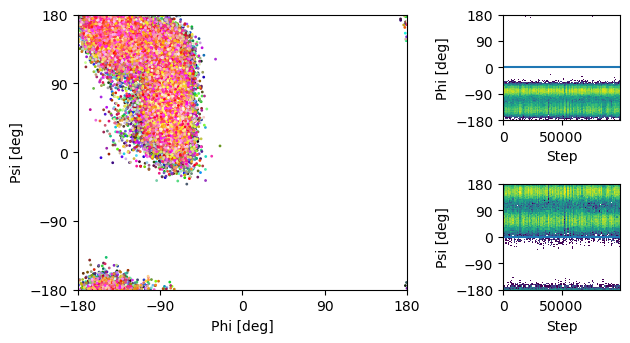

In [49]:
plot_ramachandran(traj)

## Energy

<Axes: xlabel='#"Time (ps)"'>

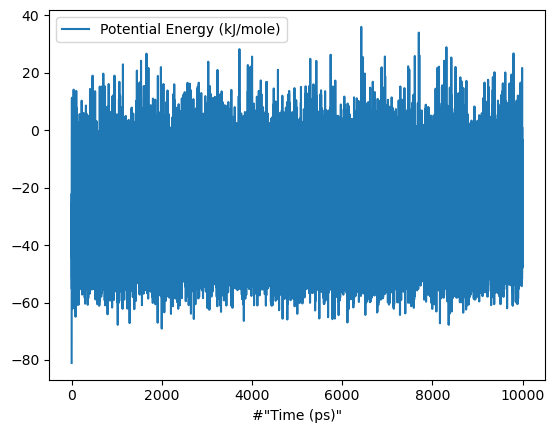

In [50]:
df1 = pd.read_csv(f"{data_dir}/{path_list[traj_idx]}/scalars.csv")
df1.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)")